# Feature engineering and preliminary modeling
convert all features into numeric features, and fit the XGboost model

In [2]:
pip install xgboost

  Using cached https://files.pythonhosted.org/packages/5e/49/b95c037b717b4ceadc76b6e164603471225c27052d1611d5a2e832757945/xgboost-0.90-py2.py3-none-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

## Load Data

In [2]:
df1 = pd.read_csv('loan_2015.csv')

C:\Users\chenj\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,80,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.shape

(421097, 108)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 108 entries, allutil to loanstatus
dtypes: float64(88), object(20)
memory usage: 347.0+ MB


In [136]:
df1.issued

0         Dec-2015
1         Dec-2015
2         Dec-2015
3         Dec-2015
4         Dec-2015
            ...   
421092    Jan-2015
421093    Jan-2015
421094    Jan-2015
421095         NaN
421096         NaN
Name: issued, Length: 421097, dtype: object

## Select Data

In [4]:
all_null_feature =['inqlast12m',
 'verificationstatusjoint',
 'maxbalbc',
 'annualincjoint',
 'memberid',
 'openil6m',
 'openacc6m',
 'totalbalil',
 'inqfi',
 'mthssincercntil',
 'openrv24m',
 'openrv12m',
 'dtijoint',
 'openil12m',
 'openil24m',
 'allutil',
 'totalcutl',
 'ilutil']

In [5]:
#  'verificationstatusjoint' have only one value
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'id',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [6]:
num_feature=['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 
             'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 
             'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 
             'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 
             'fundedamnt', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 
             'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 
             'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 
             'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 
             'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 
             'pubrecbankruptcies' ]

In [7]:
select_feature=ob_feature+num_feature
len(select_feature)

77

In [8]:
print (df1['desc'].isnull().sum())
#df1[ 'applicationtype'].value_counts()

421052


In [9]:
# remove applicationtype since it only has one value as 'individual'

ob_feature.remove('applicationtype')


In [10]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

num_feature.remove('fundedamnt')


In [11]:
# remove 'id','issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target
ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')


In [12]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')


In [13]:
select_feature=ob_feature+num_feature
len(select_feature)

71

In [14]:
# selected features left and delete the last two rows
df=df1[select_feature+['id','loanstatus','issued']][:-2]

In [15]:
df.shape

(421095, 74)

## only use term=36 months and loanstatus = fully paid and charged off

In [16]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [17]:
df.shape

(385715, 74)

In [18]:
df = df.query("term ==' 36 months'")

In [19]:
df.shape

(283169, 74)

In [20]:
ob_feature.remove('term')

## Label Target

In [21]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [22]:
print (df.loanstatus.value_counts())
print ('*'*20)
print (df.loanstatus.value_counts(normalize=True))

0    240991
1     42178
Name: loanstatus, dtype: int64
********************
0    0.85105
1    0.14895
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test

In [23]:
issued=list(df['issued'].unique())
issued

['Dec-2015',
 'Nov-2015',
 'Oct-2015',
 'Sep-2015',
 'Aug-2015',
 'Jul-2015',
 'Jun-2015',
 'May-2015',
 'Apr-2015',
 'Mar-2015',
 'Feb-2015',
 'Jan-2015']

In [24]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts(), df.train_flg.value_counts(normalize=True)

(1    194361
 0     88808
 Name: train_flg, dtype: int64, 1    0.686378
 0    0.313622
 Name: train_flg, dtype: float64)

In [25]:
issued[:3]

['Dec-2015', 'Nov-2015', 'Oct-2015']

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [26]:
df.earliestcrline.unique()[:5]

array(['Apr-2002', 'Nov-1994', 'Feb-1999', 'May-1984', 'Jun-1996'],
      dtype=object)

In [27]:
set(df.earliestcrline.unique())

{'Apr-1955',
 'Apr-1958',
 'Apr-1960',
 'Apr-1962',
 'Apr-1963',
 'Apr-1964',
 'Apr-1965',
 'Apr-1966',
 'Apr-1967',
 'Apr-1968',
 'Apr-1969',
 'Apr-1970',
 'Apr-1971',
 'Apr-1972',
 'Apr-1973',
 'Apr-1974',
 'Apr-1975',
 'Apr-1976',
 'Apr-1977',
 'Apr-1978',
 'Apr-1979',
 'Apr-1980',
 'Apr-1981',
 'Apr-1982',
 'Apr-1983',
 'Apr-1984',
 'Apr-1985',
 'Apr-1986',
 'Apr-1987',
 'Apr-1988',
 'Apr-1989',
 'Apr-1990',
 'Apr-1991',
 'Apr-1992',
 'Apr-1993',
 'Apr-1994',
 'Apr-1995',
 'Apr-1996',
 'Apr-1997',
 'Apr-1998',
 'Apr-1999',
 'Apr-2000',
 'Apr-2001',
 'Apr-2002',
 'Apr-2003',
 'Apr-2004',
 'Apr-2005',
 'Apr-2006',
 'Apr-2007',
 'Apr-2008',
 'Apr-2009',
 'Apr-2010',
 'Apr-2011',
 'Apr-2012',
 'Aug-1950',
 'Aug-1951',
 'Aug-1955',
 'Aug-1959',
 'Aug-1960',
 'Aug-1961',
 'Aug-1963',
 'Aug-1964',
 'Aug-1965',
 'Aug-1966',
 'Aug-1967',
 'Aug-1968',
 'Aug-1969',
 'Aug-1970',
 'Aug-1971',
 'Aug-1972',
 'Aug-1973',
 'Aug-1974',
 'Aug-1975',
 'Aug-1976',
 'Aug-1977',
 'Aug-1978',
 'Aug-1979',

In [41]:
# convert to number of months to Dec 2016

In [28]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [29]:
cl_month.unique()

array(['Apr', 'Nov', 'Feb', 'May', 'Jun', 'Dec', 'Aug', 'Oct', 'Jul',
       'Sep', 'Jan', 'Mar'], dtype=object)

In [30]:
cl_year.unique()

array([2002, 1994, 1999, 1984, 1996, 2001, 2000, 1991, 1985, 2004, 2007,
       2006, 2012, 2005, 1998, 1997, 2009, 2003, 1987, 1990, 2011, 1992,
       1993, 2008, 2010, 1995, 1983, 1989, 1988, 1974, 1986, 1977, 1979,
       1982, 1980, 1968, 1976, 1981, 1978, 1975, 1972, 1969, 1973, 1970,
       1964, 1966, 1971, 1965, 1962, 1960, 1967, 1963, 1961, 1959, 1958,
       1950, 1956, 1955, 1953, 1951, 1957, 1952, 1954, 1944], dtype=int64)

In [31]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [32]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2016-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [33]:
df.earliestcrline_month[:5]

2    176
4    265
5    214
6    391
8    246
Name: earliestcrline_month, dtype: int64

In [34]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')

In [35]:
print (len(ob_feature), len(num_feature))

12 58


### emplength to numeric feature

In [36]:
df.emplength.value_counts()

10+ years    89689
2 years      25889
< 1 year     24090
3 years      23109
1 year       19240
5 years      16899
4 years      16755
8 years      14270
7 years      12162
6 years      11182
9 years      10914
Name: emplength, dtype: int64

In [37]:
print (df['emplength'].isnull().sum())
df['emplength'].unique()

18970


array(['6 years', '10+ years', '8 years', '2 years', '9 years',
       '< 1 year', '1 year', '5 years', '4 years', '3 years', nan,
       '7 years'], dtype=object)

In [38]:
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [39]:
print(df.emplength.isnull().sum())
df.emplength.value_counts()

0


 10     89689
 2      25889
 0      24090
 3      23109
 1      19240
-999    18970
 5      16899
 4      16755
 8      14270
 7      12162
 6      11182
 9      10914
Name: emplength, dtype: int64

In [40]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print (len(num_feature), len(ob_feature))

59 11


## % to numeric feature: intrate, revolutil

In [41]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [42]:
type(intrate)

pandas.core.series.Series

In [43]:
df.intrate=intrate
df.intrate[:2]

2     6.49
4    11.48
Name: intrate, dtype: float64

In [44]:
df.revolutil[:3]

2    34.5%
4    39.1%
5     5.7%
Name: revolutil, dtype: object

In [45]:
revolutil=df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)

In [46]:
df.revolutil=revolutil
df.revolutil[:3]

2    34.5
4    39.1
5     5.7
Name: revolutil, dtype: float64

In [47]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [48]:
print (len(ob_feature), len(num_feature))

9 61


#### Ordinal feature encoding : grade, subgrade

In [49]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [50]:
df.grade = df.grade.map(Dic_grade)

In [51]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [52]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [53]:
print (len(ob_feature), len(num_feature))

7 63


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [54]:
print (df.zipcode.nunique(), df.zipcode.unique()[:5])

901 ['160xx' '029xx' '293xx' '275xx' '299xx']


In [55]:
len(df.zipcode.unique())

901

In [56]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [57]:
df.zipcode[:5]

2    160
4     29
5    293
6    275
8    299
Name: zipcode, dtype: int64

In [58]:
df.zipcode.nunique()

901

In [59]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [60]:
zipcode_freq[:5]

,zipcode,0
0,7,1
1,8,2
2,10,434
3,11,144
4,12,99


In [61]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [62]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [63]:
df[['zipcode','zipcode_freq']][:5]

,zipcode,zipcode_freq
0,160,165
1,29,432
2,293,239
3,275,1083
4,299,156


In [64]:
df.zipcode_freq[:5]

0     165
1     432
2     239
3    1083
4     156
Name: zipcode_freq, dtype: int64

In [65]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print (len(ob_feature), len(num_feature))

6 65


### emptitle-frequency encoding (can do some NLP for later stage)

In [66]:
df.emptitle.nunique()

86157

In [67]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")


In [68]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print (len(ob_feature), len(num_feature))

5 66


###### Addr_state - frequency encoding

In [69]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")


In [70]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print (len(ob_feature), len(num_feature))

4 67


#### One hot encoding

In [71]:
df.purpose.value_counts()

debt_consolidation    161065
credit_card            70679
home_improvement       17168
other                  15236
major_purchase          5349
medical                 3147
car                     2769
small_business          2428
vacation                2072
moving                  2062
house                   1005
renewable_energy         185
wedding                    3
educational                1
Name: purpose, dtype: int64

In [72]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [73]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [74]:
df_dummy

,homeownership_ANY,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT,verificationstatus_Not Verified,verificationstatus_Source Verified,verificationstatus_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initialliststatus_f,initialliststatus_w
0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283164,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
283165,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
283166,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
283167,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [75]:
OHE_feature=list(df_dummy.columns.values)

In [76]:
len(OHE_feature)

23

In [77]:
OHE_feature

['homeownership_ANY',
 'homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'verificationstatus_Not Verified',
 'verificationstatus_Source Verified',
 'verificationstatus_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'initialliststatus_f',
 'initialliststatus_w']

In [78]:
df=pd.concat([df,df_dummy], axis=1 )

In [79]:
df.shape

(283169, 102)

In [80]:
for feat in dummy_feature:
    
    ob_feature.remove(feat)

In [81]:
len(num_feature)

67

In [82]:
select_feature=num_feature+OHE_feature

In [83]:
len(set(num_feature))

67

In [84]:
def Remove(duplicate): 
    final_list = [] 
    dup_list = []
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
        else:
            dup_list.append(num)            
    print(final_list , dup_list)

In [272]:
Remove(num_feature)

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies', 'earliestcrline_month', 'emplength', 'intrate', 'revo

In [85]:
len(select_feature)

90

In [86]:
select_feature.remove('zipcode')

In [87]:
len(select_feature)

89

##  XGBoost 

In [88]:
feat=select_feature
print (feat)

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies', 'earliestcrline_month', 'emplength', 'intrate', 'revo

### Preliminary manually parameter tuning based on stratified train-test split

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

In [90]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [91]:
len(set(df.columns.values))

102

In [92]:
print (df_train.shape, df_test.shape)

(194361, 102) (88808, 102)


In [93]:
df_train.loanstatus[:5]

88258    1
88260    1
88263    1
88265    0
88269    1
Name: loanstatus, dtype: int64

In [94]:
df_train[feat].shape

(194361, 89)

In [95]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2019, stratify = df_train.loanstatus )

In [96]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [97]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

C:\Users\chenj\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\chenj\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [98]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} 

In [329]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds= 50)

[0]	train-auc:0.687954	eval-auc:0.67462
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.698539	eval-auc:0.682665
[2]	train-auc:0.701463	eval-auc:0.685104
[3]	train-auc:0.703423	eval-auc:0.685984
[4]	train-auc:0.704809	eval-auc:0.686974
[5]	train-auc:0.705982	eval-auc:0.68792
[6]	train-auc:0.706481	eval-auc:0.688971
[7]	train-auc:0.707101	eval-auc:0.689044
[8]	train-auc:0.707678	eval-auc:0.689288
[9]	train-auc:0.708229	eval-auc:0.68932
[10]	train-auc:0.708734	eval-auc:0.689852
[11]	train-auc:0.709085	eval-auc:0.690171
[12]	train-auc:0.70944	eval-auc:0.690498
[13]	train-auc:0.709783	eval-auc:0.690942
[14]	train-auc:0.710334	eval-auc:0.691126
[15]	train-auc:0.710631	eval-auc:0.691311
[16]	train-auc:0.712182	eval-auc:0.692116
[17]	train-auc:0.712428	eval-auc:0.692258
[18]	train-auc:0.712559	eval-auc:0.692297
[19]	train-auc:0.712873	eval-auc:0.692492
[20]	train-auc:0.713153	eval-auc:

[191]	train-auc:0.765667	eval-auc:0.702243
[192]	train-auc:0.765987	eval-auc:0.702242
[193]	train-auc:0.766155	eval-auc:0.702233
[194]	train-auc:0.766212	eval-auc:0.702226
[195]	train-auc:0.766378	eval-auc:0.702247
[196]	train-auc:0.766515	eval-auc:0.702226
[197]	train-auc:0.766627	eval-auc:0.70227
[198]	train-auc:0.766722	eval-auc:0.702297
[199]	train-auc:0.766937	eval-auc:0.702297
[200]	train-auc:0.767031	eval-auc:0.702296
[201]	train-auc:0.767295	eval-auc:0.702276
[202]	train-auc:0.767517	eval-auc:0.702297
[203]	train-auc:0.76771	eval-auc:0.702263
[204]	train-auc:0.767965	eval-auc:0.702205
[205]	train-auc:0.768314	eval-auc:0.702137
[206]	train-auc:0.768582	eval-auc:0.702156
[207]	train-auc:0.768887	eval-auc:0.702168
[208]	train-auc:0.769257	eval-auc:0.702195
[209]	train-auc:0.769581	eval-auc:0.702168
[210]	train-auc:0.76977	eval-auc:0.702208
[211]	train-auc:0.770128	eval-auc:0.702245
[212]	train-auc:0.770342	eval-auc:0.702242
[213]	train-auc:0.770593	eval-auc:0.702187
[214]	train-au

In [99]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print ("Area under the ROC curve - validation: %f" % roc_auc)
    print ("Area under the ROC curve - train: %f" % roc_auc_1)
    print ("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - validation (AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.704231
Area under the ROC curve - train: 0.782099
Area under the ROC curve - test: 0.712948


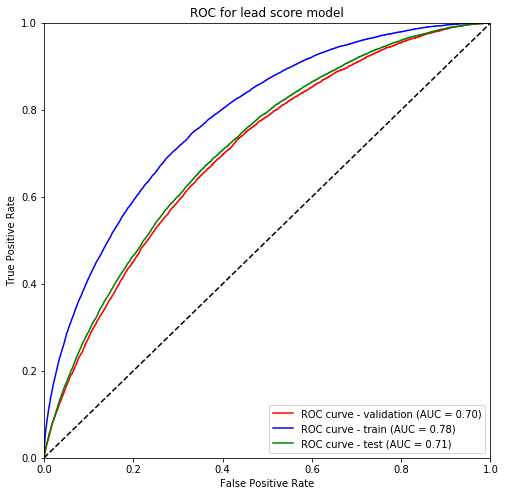

In [293]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test) 

### Distribution of predicted values

In [331]:
y_test.mean()

0.14844383388883883

In [332]:
y_pred = gbm.predict(dtest)

In [333]:
print (y_pred.max(), y_pred.min(), y_pred.mean())

0.7515882 0.0033638503 0.13986547


(array([2.6630e+04, 2.9681e+04, 1.7636e+04, 9.0260e+03, 3.7920e+03,
        1.3890e+03, 4.6900e+02, 1.4100e+02, 3.7000e+01, 7.0000e+00]),
 array([0.00336385, 0.07818629, 0.15300873, 0.22783117, 0.3026536 ,
        0.37747604, 0.45229846, 0.5271209 , 0.6019434 , 0.6767658 ,
        0.7515882 ], dtype=float32),
 <a list of 10 Patch objects>)

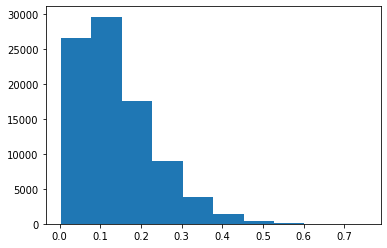

In [334]:
plt.hist(y_pred)

### Feature importance

In [335]:
importance=gbm.get_fscore()

In [336]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [344]:
df_importance.sort_values(['fscore'], ascending=True, inplace=True)
df_importance

,feature,fscore
83,numtl30dpd,0.000075
80,purpose_house,0.000075
76,purpose_major_purchase,0.000075
82,purpose_car,0.000149
81,chargeoffwithin12mths,0.000149
...,...,...
21,installment,0.031283
2,mosinoldrevtlop,0.032029
33,emptitle_freq,0.032627
11,mosinoldilacct,0.038898


<Figure size 2304x2304 with 0 Axes>

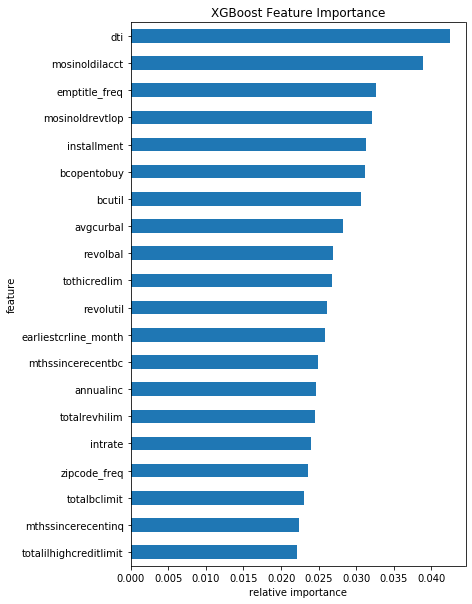

In [347]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [339]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
1,grade,0.002688


In [340]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
0,subgrade,0.011124


In [341]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
28,intrate,0.023966


In [342]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
38,loanamnt,0.016201


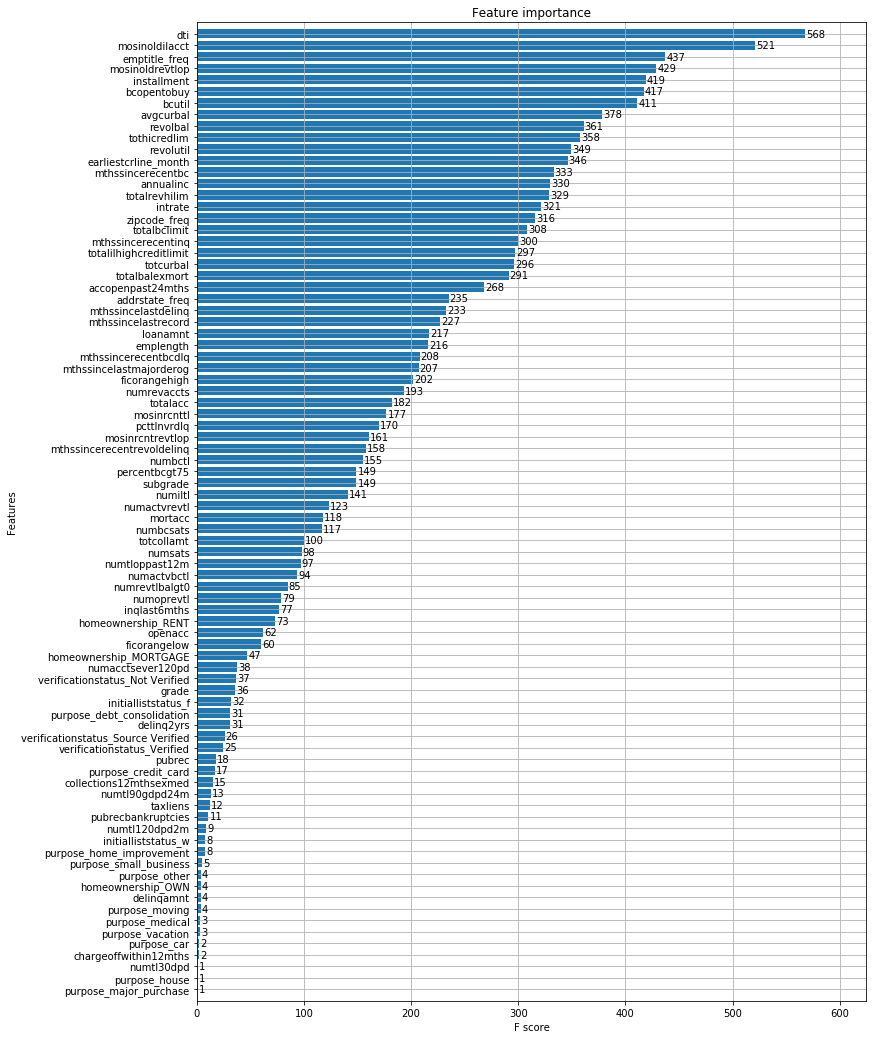

In [343]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(gbm, max_num_features=100, height=0.8, ax=ax)
plt.show()

Text(0.5, 0, 'relative importance')

<Figure size 2304x2304 with 0 Axes>

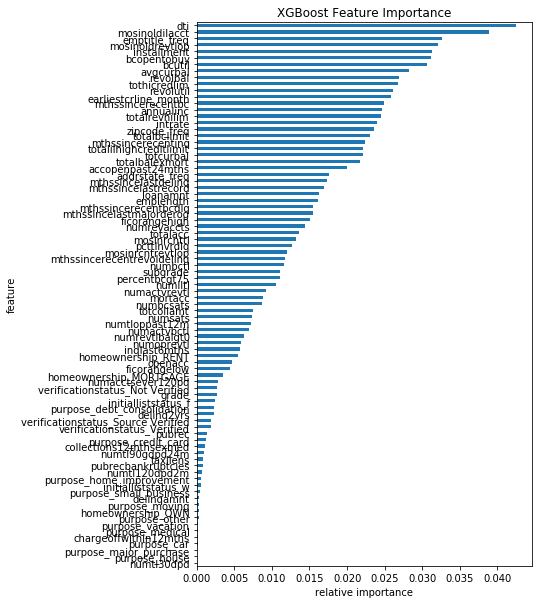

In [348]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Save model

In [310]:
import pickle

In [311]:
pickle.dump(gbm, open('p2_model.pkl', "wb"))

In [312]:
from sklearn.externals import joblib
joblib.dump(gbm, 'p2_model_2.pkl', compress=1)

C:\Users\chenj\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['p2_model_2.pkl']

In [313]:
with open('p2_model.pkl', 'wb') as outfile:
  
    pickle.dump(gbm, outfile)

In [314]:
%%timeit
with open('vector.pkl', 'wb') as f:
    pickle.dump(vector, f)
# 1 loops, best of 3: 927 ms per loop
%%timeit                                    
with open('vector.pkl', 'rb') as f:
    vector_load = pickle.load(f)

NameError: name 'vector' is not defined

In [315]:
# Compressed
%timeit joblib.dump(vector, 'vector.pkl', compress=1)
# 1 loops, best of 3: 1.58 s per loop
# file size ~ 15.1 MB
%timeit vector_load = joblib.load('vector.pkl')

NameError: name 'vector' is not defined

## Hyperparameter Tuning - Bayesian Optimization

In [350]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp37-none-any.whl size=10036 sha256=8661d665043aeb8d25a889e468cedd28f6989deb0d735a617c5b4c0ad8f9b12b
  Stored in directory: C:\Users\chenj\AppData\Local\pip\Cache\wheels\1d\0d\3b\6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization
Note: you may need to restart the kernel to use updated packages.


In [351]:
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

def xgb_evaluate(max_depth,
                 min_child_weight,
                 colsample_bytree,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 


    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[462]	train-auc:0.744063+0.00171463	test-auc:0.705882+0.00300722

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.679461       0.001282       0.677186      0.003372
1          0.684675       0.001963       0.681690      0.003323
2          0.688478       0.002311       0.684223      0.002308
3          0.689973       0.002374       0.686109      0.001600
4          0.690729       0.001726       0.687093      0.002100
..              ...            ...            ...           ...
458        0.743822       0.001702       0.705829      0.003062
459        0.743884       0.001673       0.705832      0.003065
460        0.743936

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[453]	train-auc:0.740648+0.00179629	test-auc:0.706274+0.00281173

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.680139       0.000954       0.677198      0.002841
1          0.683447       0.001842       0.680738      0.002175
2          0.687901       0.002369       0.684031      0.002012
3          0.690553       0.001610       0.687111      0.002336
4          0.691487       0.001157       0.687563      0.002822
..              ...            ...            ...           ...
449        0.740383       0.001793       0.706243      0.002828
450        0.740461       0.001815       0.706242      0.002836
451        0.740516       0.001787       0.706254      0.002832
452        0.740576       0.001777       0.706259      0.002817
453        0.740648       0.001796       0.706274      0.002812

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[572]	train-auc:0.749902+0.00234585	test-auc:0.706522+0.0030389

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.680547       0.001185       0.678266      0.002312
1          0.683969       0.001691       0.681215      0.002070
2          0.688525       0.002154       0.683907      0.002061
3          0.690169       0.002338       0.686138      0.001337
4          0.690829       0.002128       0.686619      0.001701
..              ...            ...            ...           ...
568        0.749638       0.002306       0.706517      0.003043
569        0.749703       0.002311       0.706514      0.003037
570        0.749784       0.002316       0.706514      0.003033
571        0.749849       0.002321       0.706515      0.003041
572        0.749902       0.002346       0.706522      0.003039

[573 rows x 4 columns]
|  15       |  0.7065   |  0.3743   |  1.879    |  4.02     |

Stopping. Best iteration:
[597]	train-auc:0.75186+0.0028675	test-auc:0.706319+0.00300012

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.680989       0.000693       0.678332      0.002400
1          0.686355       0.001062       0.683342      0.002592
2          0.688507       0.002176       0.684921      0.002125
3          0.689404       0.001793       0.685973      0.002120
4          0.689900       0.001664       0.686324      0.002094
..              ...            ...            ...           ...
593        0.751608       0.002892       0.706305      0.002984
594        0.751661       0.002894       0.706302      0.002985
595        0.751728       0.002890       0.706302      0.002988
596        0.751793       0.002875       0.706299      0.002988
597        0.751860       0.002867       0.706319      0.003000

[598 rows x 4 columns]
|  22       |  0.7063   |  0.5069   |  1.973    |  4.057    |  19.91    |  0.9971   |
Multiple eval metrics have been 

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.681277       0.001428       0.678819      0.002354
1          0.685921       0.001334       0.682231      0.002859
2          0.687179       0.001746       0.683383      0.001829
3          0.688252       0.001367       0.684350      0.002324
4          0.689052       0.001299       0.685093      0.002627
..              ...            ...            ...           ...
630        0.757902       0.002426       0.706385      0.003064
631        0.757959       0.002423       0.706396      0.003062
632        0.758022       0.002429       0.706407      0.003056
633        0.758106       0.002421       0.706401      0.003057
634        0.758154       0.002399       0.706415      0.003066

[635 rows x 4 columns]
|  29       |  0.7064   |  0.7979   |  0.009039 |  4.071    |  19.65    |  0.8924   |
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't impr

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[681]	train-auc:0.752574+0.002251	test-auc:0.706946+0.00296118

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.637855       0.001137       0.632308      0.000961
1          0.659650       0.016729       0.652868      0.020209
2          0.667002       0.013905       0.660220      0.018289
3          0.686602       0.001662       0.680092      0.004714
4          0.686022       0.003330       0.679523      0.007336
..              ...            ...            ...           ...
677        0.752327       0.002289       0.706929      0.002943
678        0.752402       0.002284       0.706925      0.002948
679        0.752455       0.002301       0.706937      0.002942
680        0.752520       0.002282       0.706930      0.002939
681        0.752574       0.002251       0.706946      0.002961



Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[619]	train-auc:0.752954+0.00217578	test-auc:0.706789+0.0028971

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.681170       0.001091       0.678767      0.002443
1          0.683985       0.001309       0.681586      0.002242
2          0.688605       0.002219       0.684545      0.002089
3          0.690199       0.002589       0.686273      0.001666
4          0.690835       0.002448       0.686610      0.001733
..              ...            ...            ...           ...
615        0.752715       0.002221       0.706773      0.002902
616        0.752769       0.002222       0.706780      0.002898
617        0.752868       0.002217       0.706789      0.002880
618        0.752917       0.002198       0.706780      0.002883
619        0.752954       0.002176       0.706789      0.002897

[620 rows x 4 columns]
|  44       |  0.7068   |  0.3708   |  0.06126  |  4.081    |

## sort the results and get the best set of parameters

In [360]:
a = xgb_BO.res
a

[{'target': 0.7058823333333333,
  'params': {'colsample_bytree': 0.46132130921464215,
   'gamma': 1.0308275976663233,
   'max_depth': 4.295333980840476,
   'min_child_weight': 12.347772160265722,
   'subsample': 0.505893049437047}},
 {'target': 0.7040296666666667,
  'params': {'colsample_bytree': 0.3725346524628298,
   'gamma': 1.69097198702349,
   'max_depth': 7.037917964810978,
   'min_child_weight': 3.688081556249261,
   'subsample': 0.6335907420973879}},
 {'target': 0.7057093333333334,
  'params': {'colsample_bytree': 0.4256007351593813,
   'gamma': 0.3420540866277546,
   'max_depth': 4.266352772406227,
   'min_child_weight': 2.8385833330230326,
   'subsample': 0.6545492794550569}},
 {'target': 0.705124,
  'params': {'colsample_bytree': 0.3104212541462923,
   'gamma': 1.1036333954522937,
   'max_depth': 7.963228348068861,
   'min_child_weight': 8.154912111103386,
   'subsample': 0.8544176383867406}},
 {'target': 0.7061213333333334,
  'params': {'colsample_bytree': 0.654957241565467

In [379]:
b=[]
for i in a:
    d={'target': i['target']}
    d.update(i['params'])
    b.append(d)
b

[{'target': 0.7058823333333333,
  'colsample_bytree': 0.46132130921464215,
  'gamma': 1.0308275976663233,
  'max_depth': 4.295333980840476,
  'min_child_weight': 12.347772160265722,
  'subsample': 0.505893049437047},
 {'target': 0.7040296666666667,
  'colsample_bytree': 0.3725346524628298,
  'gamma': 1.69097198702349,
  'max_depth': 7.037917964810978,
  'min_child_weight': 3.688081556249261,
  'subsample': 0.6335907420973879},
 {'target': 0.7057093333333334,
  'colsample_bytree': 0.4256007351593813,
  'gamma': 0.3420540866277546,
  'max_depth': 4.266352772406227,
  'min_child_weight': 2.8385833330230326,
  'subsample': 0.6545492794550569},
 {'target': 0.705124,
  'colsample_bytree': 0.3104212541462923,
  'gamma': 1.1036333954522937,
  'max_depth': 7.963228348068861,
  'min_child_weight': 8.154912111103386,
  'subsample': 0.8544176383867406},
 {'target': 0.7061213333333334,
  'colsample_bytree': 0.6549572415654675,
  'gamma': 0.783294805348927,
  'max_depth': 5.713174626529745,
  'min_c

In [382]:
xgb_BO_scores = pd.DataFrame(b)

In [383]:
xgb_BO_scores = xgb_BO_scores.sort_values(by='target',ascending=False)

In [384]:
xgb_BO_scores.head(3)

,target,colsample_bytree,gamma,max_depth,min_child_weight,subsample
11,0.707049,0.381960,0.314513,4.051868,19.985012,0.972280
36,0.706946,0.219531,0.006898,4.112740,19.990007,0.939969
43,0.706789,0.370796,0.061258,4.081463,19.929732,0.913108


In [386]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 20   
                  , 'subsample': 0.97228   
                  , 'colsample_bytree': 0.381960  
                  , 'gamma': 0.314513               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 1}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

# [2533]	train-auc:0.745043	eval-auc:0.704243 old
# [2533]	train-auc:0.744984	eval-auc:0.704316

[0]	train-auc:0.680358	eval-auc:0.676546
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.682742	eval-auc:0.678015
[2]	train-auc:0.68569	eval-auc:0.680517
[3]	train-auc:0.686955	eval-auc:0.68137
[4]	train-auc:0.687756	eval-auc:0.681758
[5]	train-auc:0.689028	eval-auc:0.68316
[6]	train-auc:0.689466	eval-auc:0.6838
[7]	train-auc:0.689416	eval-auc:0.683906
[8]	train-auc:0.689651	eval-auc:0.683842
[9]	train-auc:0.690227	eval-auc:0.684445
[10]	train-auc:0.69067	eval-auc:0.684952
[11]	train-auc:0.692045	eval-auc:0.686156
[12]	train-auc:0.692077	eval-auc:0.686019
[13]	train-auc:0.692827	eval-auc:0.686423
[14]	train-auc:0.69282	eval-auc:0.686326
[15]	train-auc:0.692799	eval-auc:0.686283
[16]	train-auc:0.693809	eval-auc:0.687239
[17]	train-auc:0.693879	eval-auc:0.687285
[18]	train-auc:0.693803	eval-auc:0.687156
[19]	train-auc:0.693823	eval-auc:0.687204
[20]	train-auc:0.694633	eval-auc:0.6

[191]	train-auc:0.701154	eval-auc:0.692347
[192]	train-auc:0.701166	eval-auc:0.692355
[193]	train-auc:0.701171	eval-auc:0.692356
[194]	train-auc:0.701175	eval-auc:0.692352
[195]	train-auc:0.701243	eval-auc:0.69239
[196]	train-auc:0.701258	eval-auc:0.692404
[197]	train-auc:0.701283	eval-auc:0.692403
[198]	train-auc:0.701344	eval-auc:0.692436
[199]	train-auc:0.701362	eval-auc:0.692459
[200]	train-auc:0.701454	eval-auc:0.692504
[201]	train-auc:0.701464	eval-auc:0.692512
[202]	train-auc:0.701486	eval-auc:0.692524
[203]	train-auc:0.701492	eval-auc:0.692533
[204]	train-auc:0.701528	eval-auc:0.692564
[205]	train-auc:0.701542	eval-auc:0.692563
[206]	train-auc:0.701543	eval-auc:0.69259
[207]	train-auc:0.701568	eval-auc:0.692599
[208]	train-auc:0.70166	eval-auc:0.692668
[209]	train-auc:0.701681	eval-auc:0.692693
[210]	train-auc:0.701692	eval-auc:0.692702
[211]	train-auc:0.701688	eval-auc:0.692708
[212]	train-auc:0.701699	eval-auc:0.692717
[213]	train-auc:0.701698	eval-auc:0.692701
[214]	train-au

[383]	train-auc:0.707124	eval-auc:0.695707
[384]	train-auc:0.707152	eval-auc:0.695713
[385]	train-auc:0.707169	eval-auc:0.695718
[386]	train-auc:0.707193	eval-auc:0.695731
[387]	train-auc:0.707239	eval-auc:0.695753
[388]	train-auc:0.707293	eval-auc:0.695786
[389]	train-auc:0.707314	eval-auc:0.695793
[390]	train-auc:0.707346	eval-auc:0.695816
[391]	train-auc:0.707353	eval-auc:0.695823
[392]	train-auc:0.707388	eval-auc:0.695836
[393]	train-auc:0.707419	eval-auc:0.695858
[394]	train-auc:0.707452	eval-auc:0.695872
[395]	train-auc:0.707489	eval-auc:0.695879
[396]	train-auc:0.70752	eval-auc:0.69589
[397]	train-auc:0.70756	eval-auc:0.695903
[398]	train-auc:0.707573	eval-auc:0.695908
[399]	train-auc:0.707608	eval-auc:0.695924
[400]	train-auc:0.707655	eval-auc:0.695958
[401]	train-auc:0.70769	eval-auc:0.695972
[402]	train-auc:0.707715	eval-auc:0.695979
[403]	train-auc:0.707768	eval-auc:0.696014
[404]	train-auc:0.707815	eval-auc:0.696031
[405]	train-auc:0.707857	eval-auc:0.696055
[406]	train-auc

[575]	train-auc:0.71375	eval-auc:0.698577
[576]	train-auc:0.713771	eval-auc:0.698602
[577]	train-auc:0.713798	eval-auc:0.69862
[578]	train-auc:0.713846	eval-auc:0.698631
[579]	train-auc:0.713879	eval-auc:0.698638
[580]	train-auc:0.713908	eval-auc:0.698655
[581]	train-auc:0.713942	eval-auc:0.69866
[582]	train-auc:0.713966	eval-auc:0.698673
[583]	train-auc:0.713997	eval-auc:0.69867
[584]	train-auc:0.714024	eval-auc:0.698683
[585]	train-auc:0.71406	eval-auc:0.698698
[586]	train-auc:0.71408	eval-auc:0.698708
[587]	train-auc:0.71411	eval-auc:0.698713
[588]	train-auc:0.714143	eval-auc:0.698735
[589]	train-auc:0.714172	eval-auc:0.698749
[590]	train-auc:0.714206	eval-auc:0.698759
[591]	train-auc:0.714237	eval-auc:0.698766
[592]	train-auc:0.714268	eval-auc:0.698787
[593]	train-auc:0.714293	eval-auc:0.698796
[594]	train-auc:0.714318	eval-auc:0.698801
[595]	train-auc:0.714349	eval-auc:0.698808
[596]	train-auc:0.714378	eval-auc:0.698812
[597]	train-auc:0.714409	eval-auc:0.698824
[598]	train-auc:0.

[767]	train-auc:0.71872	eval-auc:0.70026
[768]	train-auc:0.718743	eval-auc:0.700266
[769]	train-auc:0.718773	eval-auc:0.700275
[770]	train-auc:0.718799	eval-auc:0.700274
[771]	train-auc:0.718829	eval-auc:0.700275
[772]	train-auc:0.718852	eval-auc:0.700284
[773]	train-auc:0.718867	eval-auc:0.700289
[774]	train-auc:0.718896	eval-auc:0.700295
[775]	train-auc:0.718926	eval-auc:0.7003
[776]	train-auc:0.718936	eval-auc:0.700304
[777]	train-auc:0.718956	eval-auc:0.700317
[778]	train-auc:0.718976	eval-auc:0.700321
[779]	train-auc:0.718996	eval-auc:0.700335
[780]	train-auc:0.71902	eval-auc:0.700346
[781]	train-auc:0.719046	eval-auc:0.700354
[782]	train-auc:0.719074	eval-auc:0.700361
[783]	train-auc:0.719094	eval-auc:0.70037
[784]	train-auc:0.719116	eval-auc:0.700375
[785]	train-auc:0.719145	eval-auc:0.700376
[786]	train-auc:0.719162	eval-auc:0.700374
[787]	train-auc:0.719185	eval-auc:0.700382
[788]	train-auc:0.719209	eval-auc:0.700383
[789]	train-auc:0.719221	eval-auc:0.70039
[790]	train-auc:0.

[959]	train-auc:0.72265	eval-auc:0.701283
[960]	train-auc:0.722655	eval-auc:0.701284
[961]	train-auc:0.722674	eval-auc:0.701288
[962]	train-auc:0.722703	eval-auc:0.701295
[963]	train-auc:0.722733	eval-auc:0.701293
[964]	train-auc:0.722753	eval-auc:0.701301
[965]	train-auc:0.722774	eval-auc:0.701299
[966]	train-auc:0.722799	eval-auc:0.701307
[967]	train-auc:0.722818	eval-auc:0.70131
[968]	train-auc:0.722843	eval-auc:0.701315
[969]	train-auc:0.722869	eval-auc:0.701327
[970]	train-auc:0.722892	eval-auc:0.701329
[971]	train-auc:0.722918	eval-auc:0.701332
[972]	train-auc:0.722937	eval-auc:0.70133
[973]	train-auc:0.722956	eval-auc:0.701331
[974]	train-auc:0.722964	eval-auc:0.701336
[975]	train-auc:0.722976	eval-auc:0.701348
[976]	train-auc:0.722995	eval-auc:0.701347
[977]	train-auc:0.723015	eval-auc:0.701356
[978]	train-auc:0.723038	eval-auc:0.701359
[979]	train-auc:0.723057	eval-auc:0.701366
[980]	train-auc:0.72308	eval-auc:0.701378
[981]	train-auc:0.723098	eval-auc:0.70138
[982]	train-auc:

[1148]	train-auc:0.726055	eval-auc:0.702087
[1149]	train-auc:0.726067	eval-auc:0.702095
[1150]	train-auc:0.726081	eval-auc:0.702103
[1151]	train-auc:0.726096	eval-auc:0.702108
[1152]	train-auc:0.726129	eval-auc:0.702116
[1153]	train-auc:0.726146	eval-auc:0.702119
[1154]	train-auc:0.726156	eval-auc:0.702124
[1155]	train-auc:0.726166	eval-auc:0.702126
[1156]	train-auc:0.726184	eval-auc:0.702124
[1157]	train-auc:0.726205	eval-auc:0.702132
[1158]	train-auc:0.726225	eval-auc:0.702134
[1159]	train-auc:0.72624	eval-auc:0.702132
[1160]	train-auc:0.726262	eval-auc:0.702136
[1161]	train-auc:0.726276	eval-auc:0.702147
[1162]	train-auc:0.72628	eval-auc:0.702147
[1163]	train-auc:0.726302	eval-auc:0.70215
[1164]	train-auc:0.726318	eval-auc:0.702153
[1165]	train-auc:0.726341	eval-auc:0.702159
[1166]	train-auc:0.726352	eval-auc:0.702158
[1167]	train-auc:0.726368	eval-auc:0.702165
[1168]	train-auc:0.726374	eval-auc:0.702169
[1169]	train-auc:0.726394	eval-auc:0.702165
[1170]	train-auc:0.72641	eval-auc:0

[1335]	train-auc:0.728974	eval-auc:0.702685
[1336]	train-auc:0.728982	eval-auc:0.702688
[1337]	train-auc:0.729007	eval-auc:0.702697
[1338]	train-auc:0.729026	eval-auc:0.702703
[1339]	train-auc:0.729037	eval-auc:0.702707
[1340]	train-auc:0.729045	eval-auc:0.702703
[1341]	train-auc:0.729059	eval-auc:0.702704
[1342]	train-auc:0.729075	eval-auc:0.702705
[1343]	train-auc:0.729095	eval-auc:0.702706
[1344]	train-auc:0.729121	eval-auc:0.702715
[1345]	train-auc:0.729147	eval-auc:0.702715
[1346]	train-auc:0.729156	eval-auc:0.702723
[1347]	train-auc:0.729176	eval-auc:0.70273
[1348]	train-auc:0.729191	eval-auc:0.702734
[1349]	train-auc:0.729202	eval-auc:0.702738
[1350]	train-auc:0.729218	eval-auc:0.70274
[1351]	train-auc:0.729227	eval-auc:0.702738
[1352]	train-auc:0.729234	eval-auc:0.702738
[1353]	train-auc:0.729243	eval-auc:0.702738
[1354]	train-auc:0.729248	eval-auc:0.702736
[1355]	train-auc:0.729264	eval-auc:0.702733
[1356]	train-auc:0.729277	eval-auc:0.702733
[1357]	train-auc:0.729289	eval-auc

[1523]	train-auc:0.731823	eval-auc:0.703103
[1524]	train-auc:0.731831	eval-auc:0.703103
[1525]	train-auc:0.731845	eval-auc:0.703104
[1526]	train-auc:0.731861	eval-auc:0.703104
[1527]	train-auc:0.731878	eval-auc:0.703107
[1528]	train-auc:0.731898	eval-auc:0.703111
[1529]	train-auc:0.731915	eval-auc:0.703116
[1530]	train-auc:0.731921	eval-auc:0.703116
[1531]	train-auc:0.731935	eval-auc:0.703116
[1532]	train-auc:0.731946	eval-auc:0.70311
[1533]	train-auc:0.73195	eval-auc:0.703111
[1534]	train-auc:0.73197	eval-auc:0.703108
[1535]	train-auc:0.731984	eval-auc:0.70311
[1536]	train-auc:0.731994	eval-auc:0.703113
[1537]	train-auc:0.732015	eval-auc:0.703111
[1538]	train-auc:0.732021	eval-auc:0.703116
[1539]	train-auc:0.73203	eval-auc:0.703114
[1540]	train-auc:0.732037	eval-auc:0.703112
[1541]	train-auc:0.732049	eval-auc:0.703115
[1542]	train-auc:0.732067	eval-auc:0.703114
[1543]	train-auc:0.732071	eval-auc:0.703112
[1544]	train-auc:0.732089	eval-auc:0.703112
[1545]	train-auc:0.732109	eval-auc:0.

[1710]	train-auc:0.734422	eval-auc:0.703401
[1711]	train-auc:0.734436	eval-auc:0.703403
[1712]	train-auc:0.73445	eval-auc:0.703404
[1713]	train-auc:0.734456	eval-auc:0.703406
[1714]	train-auc:0.73447	eval-auc:0.703409
[1715]	train-auc:0.734482	eval-auc:0.703411
[1716]	train-auc:0.734498	eval-auc:0.703412
[1717]	train-auc:0.734509	eval-auc:0.703418
[1718]	train-auc:0.734533	eval-auc:0.703421
[1719]	train-auc:0.73455	eval-auc:0.703426
[1720]	train-auc:0.734564	eval-auc:0.703429
[1721]	train-auc:0.734567	eval-auc:0.70343
[1722]	train-auc:0.734576	eval-auc:0.703429
[1723]	train-auc:0.734584	eval-auc:0.703428
[1724]	train-auc:0.734604	eval-auc:0.703427
[1725]	train-auc:0.734622	eval-auc:0.703422
[1726]	train-auc:0.734629	eval-auc:0.703422
[1727]	train-auc:0.734651	eval-auc:0.703429
[1728]	train-auc:0.734666	eval-auc:0.703432
[1729]	train-auc:0.734674	eval-auc:0.703431
[1730]	train-auc:0.734683	eval-auc:0.703431
[1731]	train-auc:0.734698	eval-auc:0.703427
[1732]	train-auc:0.734709	eval-auc:0

[1898]	train-auc:0.737016	eval-auc:0.703625
[1899]	train-auc:0.737033	eval-auc:0.703628
[1900]	train-auc:0.737045	eval-auc:0.703628
[1901]	train-auc:0.737048	eval-auc:0.703632
[1902]	train-auc:0.737052	eval-auc:0.703629
[1903]	train-auc:0.737071	eval-auc:0.703634
[1904]	train-auc:0.737074	eval-auc:0.703634
[1905]	train-auc:0.737096	eval-auc:0.703638
[1906]	train-auc:0.737109	eval-auc:0.703637
[1907]	train-auc:0.73712	eval-auc:0.703635
[1908]	train-auc:0.737135	eval-auc:0.703632
[1909]	train-auc:0.737152	eval-auc:0.703634
[1910]	train-auc:0.737168	eval-auc:0.703633
[1911]	train-auc:0.737179	eval-auc:0.70363
[1912]	train-auc:0.737184	eval-auc:0.703632
[1913]	train-auc:0.737199	eval-auc:0.703631
[1914]	train-auc:0.737204	eval-auc:0.703632
[1915]	train-auc:0.737226	eval-auc:0.703635
[1916]	train-auc:0.737234	eval-auc:0.703636
[1917]	train-auc:0.737252	eval-auc:0.703643
[1918]	train-auc:0.737266	eval-auc:0.703635
[1919]	train-auc:0.737273	eval-auc:0.703636
[1920]	train-auc:0.737294	eval-auc

[2086]	train-auc:0.739482	eval-auc:0.703866
[2087]	train-auc:0.739498	eval-auc:0.703867
[2088]	train-auc:0.739502	eval-auc:0.703865
[2089]	train-auc:0.73951	eval-auc:0.703864
[2090]	train-auc:0.739531	eval-auc:0.703861
[2091]	train-auc:0.739537	eval-auc:0.703859
[2092]	train-auc:0.73955	eval-auc:0.703858
[2093]	train-auc:0.739567	eval-auc:0.70386
[2094]	train-auc:0.73958	eval-auc:0.703859
[2095]	train-auc:0.739585	eval-auc:0.703857
[2096]	train-auc:0.739605	eval-auc:0.70386
[2097]	train-auc:0.739617	eval-auc:0.703857
[2098]	train-auc:0.739642	eval-auc:0.703854
[2099]	train-auc:0.739652	eval-auc:0.703852
[2100]	train-auc:0.739666	eval-auc:0.703851
[2101]	train-auc:0.73967	eval-auc:0.703848
[2102]	train-auc:0.739679	eval-auc:0.703845
[2103]	train-auc:0.739686	eval-auc:0.703846
[2104]	train-auc:0.739703	eval-auc:0.703847
[2105]	train-auc:0.73971	eval-auc:0.703847
[2106]	train-auc:0.739731	eval-auc:0.70385
[2107]	train-auc:0.739751	eval-auc:0.70386
[2108]	train-auc:0.739756	eval-auc:0.7038

[2274]	train-auc:0.741802	eval-auc:0.704063
[2275]	train-auc:0.741819	eval-auc:0.704062
[2276]	train-auc:0.741834	eval-auc:0.704066
[2277]	train-auc:0.741853	eval-auc:0.70407
[2278]	train-auc:0.741874	eval-auc:0.704068
[2279]	train-auc:0.74188	eval-auc:0.704068
[2280]	train-auc:0.741887	eval-auc:0.704068
[2281]	train-auc:0.7419	eval-auc:0.704068
[2282]	train-auc:0.741916	eval-auc:0.704075
[2283]	train-auc:0.741925	eval-auc:0.704076
[2284]	train-auc:0.741943	eval-auc:0.704075
[2285]	train-auc:0.741961	eval-auc:0.704076
[2286]	train-auc:0.741973	eval-auc:0.704073
[2287]	train-auc:0.741998	eval-auc:0.704078
[2288]	train-auc:0.742007	eval-auc:0.704077
[2289]	train-auc:0.742011	eval-auc:0.70408
[2290]	train-auc:0.742016	eval-auc:0.704081
[2291]	train-auc:0.742022	eval-auc:0.70408
[2292]	train-auc:0.742027	eval-auc:0.704077
[2293]	train-auc:0.742029	eval-auc:0.704075
[2294]	train-auc:0.742042	eval-auc:0.70408
[2295]	train-auc:0.742055	eval-auc:0.704085
[2296]	train-auc:0.742058	eval-auc:0.70

[2462]	train-auc:0.74412	eval-auc:0.704267
[2463]	train-auc:0.744135	eval-auc:0.704266
[2464]	train-auc:0.744139	eval-auc:0.704265
[2465]	train-auc:0.744157	eval-auc:0.704265
[2466]	train-auc:0.744162	eval-auc:0.704264
[2467]	train-auc:0.744178	eval-auc:0.704265
[2468]	train-auc:0.744189	eval-auc:0.704268
[2469]	train-auc:0.744208	eval-auc:0.704275
[2470]	train-auc:0.744223	eval-auc:0.704277
[2471]	train-auc:0.744245	eval-auc:0.70428
[2472]	train-auc:0.744264	eval-auc:0.704278
[2473]	train-auc:0.744277	eval-auc:0.704279
[2474]	train-auc:0.744294	eval-auc:0.704279
[2475]	train-auc:0.744307	eval-auc:0.704281
[2476]	train-auc:0.744333	eval-auc:0.704283
[2477]	train-auc:0.744344	eval-auc:0.704282
[2478]	train-auc:0.744351	eval-auc:0.704282
[2479]	train-auc:0.744363	eval-auc:0.704282
[2480]	train-auc:0.744369	eval-auc:0.704281
[2481]	train-auc:0.744386	eval-auc:0.70428
[2482]	train-auc:0.7444	eval-auc:0.704283
[2483]	train-auc:0.744408	eval-auc:0.704283
[2484]	train-auc:0.744421	eval-auc:0.

## train model with tuned parameters

In [387]:
best_xgb_iteration=2533
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 20
                  , subsample = 0.97228
                  , colsample_bytree = 0.381960 
                  , gamma = 0.314513
                  , seed = 1234
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.38196, gamma=0.314513,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=20, missing=None, n_estimators=2533, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
              silent=None, subsample=0.97228, verbosity=1)

## validate on test data

Area under the ROC curve - validation: 0.704316
Area under the ROC curve - train: 0.744984
Area under the ROC curve - test: 0.714012


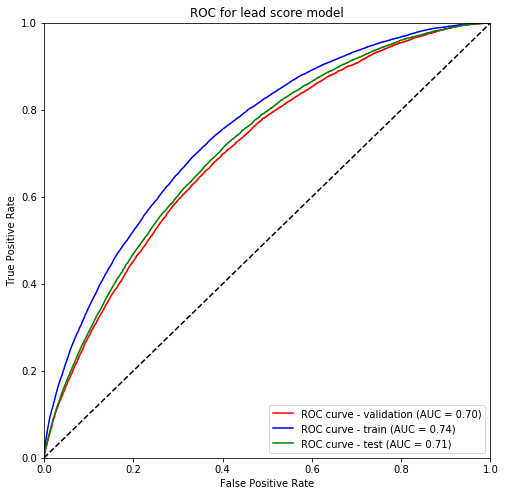

In [388]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [389]:
y_pred = gbm.predict(dtest)

In [391]:
print (y_pred.max(), y_pred.min(), y_pred.mean())

0.70163935 0.005153708 0.14047325


In [392]:
importance=gbm.get_fscore()

In [393]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [394]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
10,dti,0.041866
8,installment,0.033034
13,intrate,0.031089
29,mosinoldrevtlop,0.030929
4,avgcurbal,0.030036
...,...,...
75,purpose_vacation,0.000223
78,purpose_moving,0.000191
77,purpose_medical,0.000064
80,delinqamnt,0.000064


<Figure size 2304x2304 with 0 Axes>

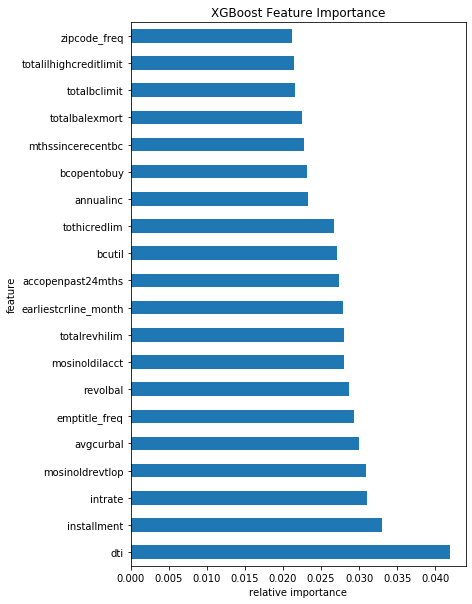

In [395]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## save model

In [ ]:
import pickle

In [ ]:
with open('model.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [ ]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")